In [4]:
import json
import pandas as pd
import numpy as np
import sys
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
import matplotlib.pyplot as plt
from roc_utils import *
from auc_delong_xu import auc_ci_Delong
import roc_utils


In [7]:
df =  pd.read_csv("/Users/jerry/Desktop/CSE Capstone/hallucinated-references/data/gpt-4_results.csv")

In [8]:
df["bing_return"].value_counts()

bing_return
True     532
False    468
Name: count, dtype: int64

### ROC Plots

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

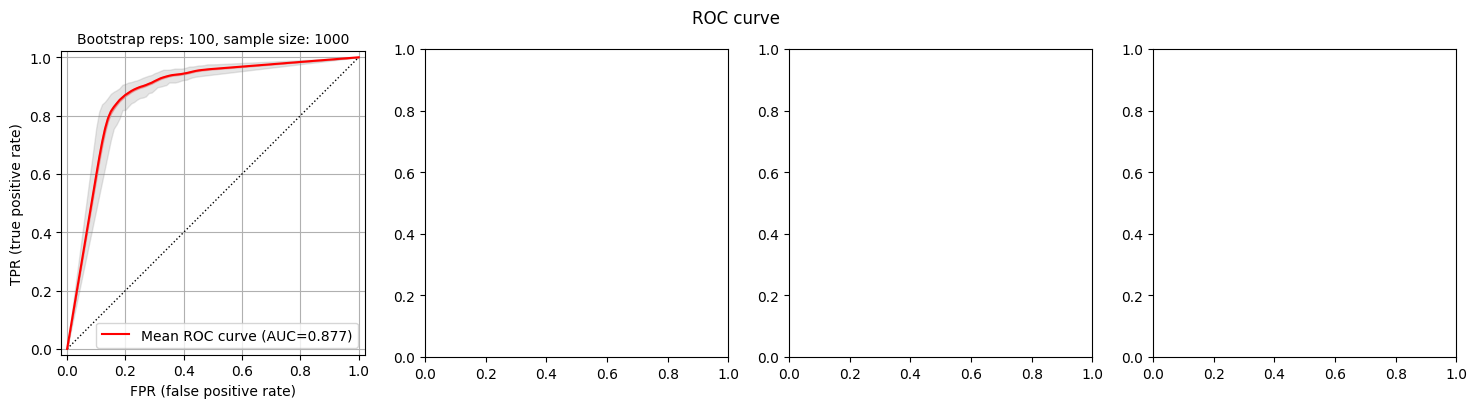

In [9]:
pos_label = 1
n_samples = 100
# aIQuming your dataframe is called df and has columns "probs" and "ground truth"
list_baselines =  ["IQ","DQ1","DQ2","DQ3"]#,"IQ+DQ2"]
dict_baselines = {"IQ":{"ground_truth" : None, "probs" : None},"DQ1":{"ground_truth" : None, "probs" : None},"DQ2":{"ground_truth" : None, "probs" : None},"DQ3":{"ground_truth" : None, "probs" : None}}#, "IQ+DQ2" : {"ground_truth" : None, "probs" : None}}

probs = df["neural_ans1_prob"].values
dict_baselines["IQ"]["probs"] = 1 - probs
ground_truth = df["bing_return"].values
ground_truth = [0 if x == True else 1 for x in ground_truth]
ground_truth = np.array(ground_truth)
dict_baselines["IQ"]["ground_truth"] = ground_truth

probs = df["neural_ans2_prob"].values
dict_baselines["DQ1"]["probs"] = 1 - probs
ground_truth = df["bing_return"].values
ground_truth = [0 if x == True else 1 for x in ground_truth]
ground_truth = np.array(ground_truth)
dict_baselines["DQ1"]["ground_truth"] = ground_truth

probs = df["neural_ans3_prob"].values
dict_baselines["DQ2"]["probs"] = 1 - probs
ground_truth = df["bing_return"].values
ground_truth = [0 if x == True else 1 for x in ground_truth]
ground_truth = np.array(ground_truth)
dict_baselines["DQ2"]["ground_truth"] = ground_truth

probs = df["neural_ans4_prob"].values
dict_baselines["DQ3"]["probs"] = 1 - probs
ground_truth = df["bing_return"].values
ground_truth = [0 if x == True else 1 for x in ground_truth]
ground_truth = np.array(ground_truth)
dict_baselines["DQ3"]["ground_truth"] = ground_truth


fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# loop over the subplots and plot the ROC curve for each one
for i, ax in enumerate(axes):
    # calculate the fpr and tpr for all thresholds of the claIQification
    ground_truth = dict_baselines[list_baselines[i]]["ground_truth"]
    probs = dict_baselines[list_baselines[i]]["probs"]
    ret_mean = plot_roc_bootstrap(X=probs, y=ground_truth, pos_label=pos_label,
                   n_bootstrap=n_samples,
                   random_state=42,
                   show_boots=False,
                   ax=ax)
    auc, auc_var, ci = auc_ci_Delong(y_true=ground_truth,y_scores=probs)
    error_delta =  ret_mean["auc_mean"] - ci[0]
    ax.set_title(f'ROC: {list_baselines[i]}, AUC: {ret_mean["auc_mean"]:.3f} ± {error_delta:.2f}',fontsize=15)
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    if i > 0:
        ax.set_xlabel('1 - G accuracy',fontsize=15)
        ax.set_ylabel('',fontsize=15)
        continue
    ax.set_ylabel('H accuracy',fontsize=15)
    ax.set_xlabel('1 - G accuracy',fontsize=15)
plt.show()

- Combined ROC Plots

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

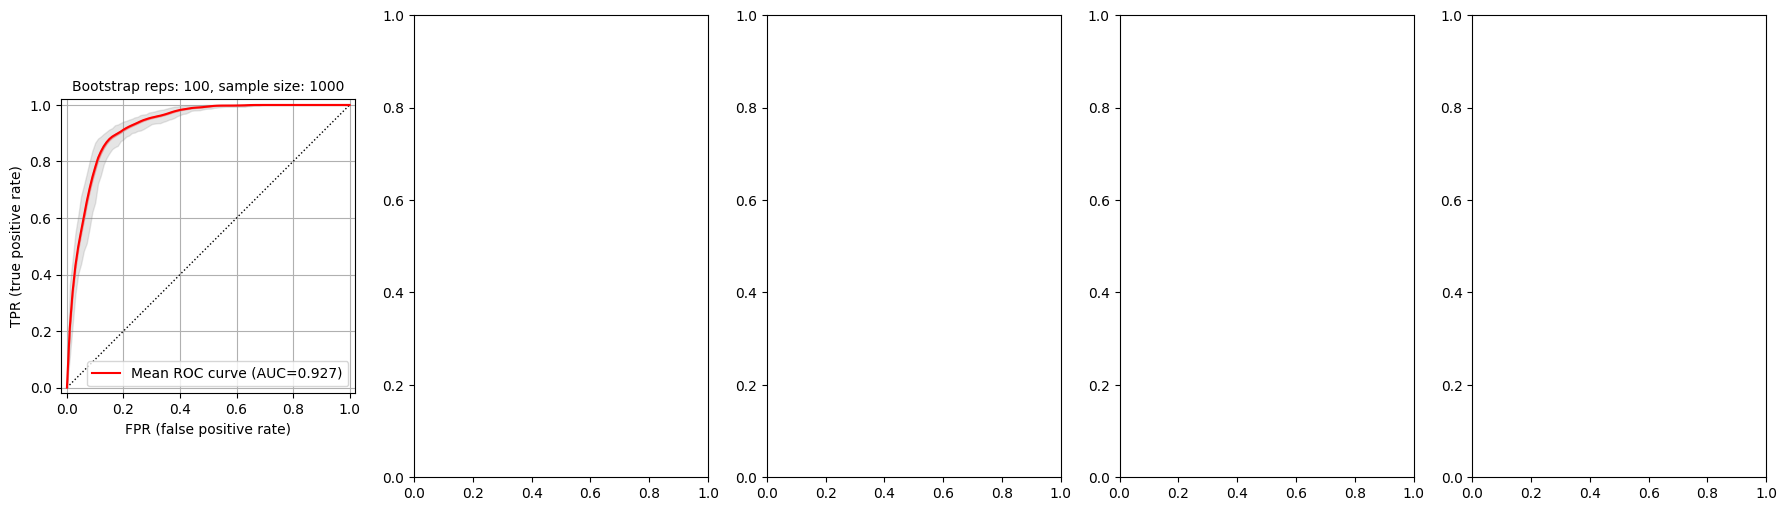

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from roc_utils import *

pos_label = 1
n_samples = 100
# aIQuming your dataframe is called df and has columns "probs" and "ground truth"
list_baselines =  ["IQ","DQ1","DQ2","DQ3","IQ+DQ","DQ","IQ+DQ1","IQ+DQ2","IQ+DQ3"]#,"IQ+DQ2"]
dict_baselines = {"IQ":  None,"DQ1": None,"DQ2":  None,"DQ3": None,"IQ+DQ" : None,"DQ" : None, "IQ+DQ1": None, "IQ+DQ2": None, "IQ+DQ3": None}

ground_truth = df["bing_return"].values
ground_truth = [0 if x == True else 1 for x in ground_truth]
ground_truth = np.array(ground_truth)


probs = df["neural_ans1_prob"].values
dict_baselines["IQ"] = 1 - probs

probs = df["neural_ans2_prob"].values
dict_baselines["DQ1"] = 1 - probs

probs = df["neural_ans3_prob"].values
dict_baselines["DQ2"] = 1 - probs


probs = df["neural_ans4_prob"].values
dict_baselines["DQ3"] = 1 - probs

#probs = df["neural_ans4_prob"].values
dict_baselines["DQ"] = np.mean([dict_baselines["DQ1"],dict_baselines["DQ2"],dict_baselines["DQ3"]],axis=0)

dict_baselines["IQ+DQ"] = np.mean([dict_baselines["IQ"],dict_baselines["DQ"]],axis=0)
dict_baselines["IQ+DQ1"] = np.mean([dict_baselines["IQ"],dict_baselines["DQ1"]],axis=0)
dict_baselines["IQ+DQ2"] = np.mean([dict_baselines["IQ"],dict_baselines["DQ2"]],axis=0)
dict_baselines["IQ+DQ3"] = np.mean([dict_baselines["IQ"],dict_baselines["DQ3"]],axis=0)

# create a figure with four subplots
fig, axes = plt.subplots(1, 5, figsize=(22, 6))

# loop over the subplots and plot the ROC curve for each one
for i, ax in enumerate(axes):
    # calculate the fpr and tpr for all thresholds of the claIQification
    probs = dict_baselines[list_baselines[i+4]]
    ret_mean = plot_roc_bootstrap(X=probs, y=ground_truth, pos_label=pos_label,
                   n_bootstrap=n_samples,
                   random_state=42,
                   show_boots=False,
                   title="",
                   ax=ax)
    auc, auc_var, ci = auc_ci_Delong(y_true=ground_truth,y_scores=probs)
    error_delta =  ret_mean["auc_mean"] - ci[0]
    ax.set_title(f'{list_baselines[i+4]}, AUC: {ret_mean["auc_mean"]:.3f} ± {error_delta:.2f}',fontsize=15)
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([-0.05, 1])
    ax.set_ylim([0, 1.05])
    if i > 0:
        ax.set_xlabel('1 - G accuracy',fontsize=15)
        ax.set_ylabel('',fontsize=15)
        continue
    ax.set_ylabel('H accuracy',fontsize=15)
    ax.set_xlabel('1 - G accuracy',fontsize=15)
    
#plt.show()

### FDR curves

In [11]:
def get_fdr_boot_extended(x_boot,y_boot,return_min,col_name):
    thresholds = np.linspace(-0.05, 0.99, 50)
    error_tolerance = 0.001
    
    fdr = []
    returns = []
    df_boot = pd.concat([x_boot,y_boot],axis=1)    
    #glob_lis = []
    min_returns = 10000
    min_threshold = 10000
    for threshold in thresholds:
        df_boot_TP = df_boot[(df_boot[col_name] <= threshold) & (df_boot["bing_return"] == False)]
        TP = len(df_boot_TP)
        df_boot_TN = df_boot[(df_boot[col_name] > threshold) & (df_boot["bing_return"] == True)]
        TN = len(df_boot_TN)
        df_boot_FP = df_boot[(df_boot[col_name] <= threshold) & (df_boot["bing_return"] == True)]
        FP = len(df_boot_FP)
        df_boot_FN = df_boot[(df_boot[col_name] > threshold) & (df_boot["bing_return"] == False)]
        FN = len(df_boot_FN)
        FDR = FN/(TN + FN)
        RETURNS = (TN + FN)/(TP + TN + FP + FN)
        fdr.append(FDR)
        returns.append(RETURNS)
        if RETURNS < min_returns:
            min_returns = RETURNS
            min_threshold = threshold

    assert min_threshold != 10000
    ext_x = []
    ext_y = []
    extended_points = np.linspace(0.01,min_returns, 20)
    for point in extended_points:
        num_samples_ext = int((TP + TN + FP + FN)*point)
        df_fdr_boot_ext = df_boot[(df_boot[col_name] > min_threshold)].sample(n=num_samples_ext,random_state=1)
        assert num_samples_ext == len(df_fdr_boot_ext)
        ext_FN = len(df_fdr_boot_ext[(df_fdr_boot_ext[col_name] > min_threshold) & (df_fdr_boot_ext["bing_return"] == False)])
        assert ext_FN <= len(df_fdr_boot_ext)
        ext_y.append(ext_FN/num_samples_ext)
        ext_x.append(num_samples_ext/(TP + TN + FP + FN))
        
    return fdr,returns,ext_x,ext_y

In [12]:
isinstance(42, np.random.RandomState)
if not isinstance(42, np.random.RandomState):
        random_state = np.random.RandomState(42)
random_state

RandomState(MT19937) at 0x33CF03740

In [13]:
thresholds = np.linspace(-0.05, 0.99, 50)

def get_fdr(threshold,prompt_type,df_arg):
    col = "neural_ans"+str(prompt_type)+"_prob"
    TP_df = df_arg[(df_arg[col] <= threshold) & (df_arg["bing_return"] == False)]
    TP = len(TP_df)
    TN_df = df_arg[(df_arg[col] > threshold) & (df_arg["bing_return"] == True)]
    TN = len(TN_df)
    FP_df = df_arg[(df_arg[col] <= threshold) & (df_arg["bing_return"] == True)]
    FP = len(FP_df)
    FN_df = df_arg[(df_arg[col] > threshold) & (df_arg["bing_return"] == False)]
    FN = len(FN_df)
    FDR = FN/(TN + FN)
    returns = (TN + FN)/(TP + TN + FP + FN)
    return FDR,returns
IQ_fdr = []
IQ_return = []

for i in thresholds:
    fdr,returns = get_fdr(i,1,df)
    IQ_fdr.append(fdr)
    IQ_return.append(returns)

IQ_fdr = np.array(IQ_fdr)
IQ_return = np.array(IQ_return)

DQ1_fdr = []
DQ1_return = []

for i in thresholds:
    fdr,returns = get_fdr(i,2,df)
    DQ1_fdr.append(fdr)
    DQ1_return.append(returns)
    
DQ1_fdr = np.array(DQ1_fdr)
DQ1_return = np.array(DQ1_return)

DQ2_fdr = []
DQ2_return = []
for i in thresholds:
    fdr,returns = get_fdr(i,3,df)
    DQ2_fdr.append(fdr)
    DQ2_return.append(returns)
DQ2_fdr = np.array(DQ2_fdr)
DQ2_return = np.array(DQ2_return)

DQ3_fdr = []
DQ3_return = []
for i in thresholds:
    fdr,returns = get_fdr(i,4,df)
    DQ3_fdr.append(fdr)
    DQ3_return.append(returns)
DQ3_fdr = np.array(DQ3_fdr)
DQ3_return = np.array(DQ3_return)

In [14]:
def linear_interpolation(x, y):
    def interpolate(new_x):
        if new_x <= x[0]:
            return y[0]
        elif new_x >= x[-1]:
            return y[-1]
        else:
            for i in range(len(x)-1):
                if x[i] <= new_x <= x[i+1]:
                    slope = (y[i+1] - y[i]) / (x[i+1] - x[i])
                    return y[i] + slope * (new_x - x[i])
    return interpolate

In [15]:
n_samples = 100
resolution = 101
def get_all_data_with_extension(prompt_type,return_min,return_max):
    results = []
    glob_n_lis = []
    ext_results = []
    for n_sample in range(n_samples):
        col_name = "neural_ans"+str(prompt_type)+"_prob"
        x_boot, y_boot = roc_utils._sampling.resample_data(df[col_name],df["bing_return"],random_state = random_state,replace=True,stratify=None)
        fdr,returns,ext_x,ext_y = get_fdr_boot_extended(x_boot,y_boot,return_min,col_name)
        results.append((fdr,returns))
        #glob_n_lis.extend(ext_data)
        ext_results.append((ext_x,ext_y))

    fdr_all = np.zeros((n_samples,resolution))
    mean = np.linspace(return_min,return_max,resolution)
    for i in range(n_samples):
   
        Q = list(set(zip(results[i][1],results[i][0])))
        Q.sort(key=lambda x: x[0])
        #print(Q)
        x = [i[0] for i in Q]
        y = [i[1] for i in Q]
        f = linear_interpolation(x,y)
        fdr_all[i,:] = np.array([f(j) for j in mean])

    
    ext_mean = np.linspace(0.01,return_min,20) #change the starting point for text-davinci-003
    ext_all = np.zeros((n_samples,20))
    for i in range(n_samples):
        Q = list(set(zip(ext_results[i][0],ext_results[i][1])))
        Q.sort(key=lambda x: x[0])
        #print(Q)
        x = [i[0] for i in Q]
        y = [i[1] for i in Q]
        f = linear_interpolation(x,y)
        ext_all[i,:] = np.array([f(j) for j in ext_mean])

    fdr_sort = np.sort(fdr_all, axis=0)
    fdr_lower = fdr_sort[int(0.025 * n_samples), :]
    fdr_upper = fdr_sort[int(0.975 * n_samples), :]
    fdr_std = np.std(fdr_all, axis=0, ddof=1)
    fdr_mean = np.mean(fdr_all, axis=0)
    fdr_lower_ci = fdr_mean - 1.96 * fdr_std / np.sqrt(n_samples)
    fdr_upper_ci = fdr_mean + 1.96 * fdr_std / np.sqrt(n_samples)

    ext_sort = np.sort(ext_all, axis=0)
    ext_lower = ext_sort[int(0.025 * n_samples), :]
    ext_upper = ext_sort[int(0.975 * n_samples), :]
    ext_std = np.std(ext_all, axis=0, ddof=1)
    ext_mean_fdr = np.mean(ext_all, axis=0)
    ext_lower_ci = ext_mean_fdr - 1.96 * ext_std / np.sqrt(n_samples)
    ext_upper_ci = ext_mean_fdr + 1.96 * ext_std / np.sqrt(n_samples)

    return mean,fdr_lower,fdr_upper,fdr_lower_ci,fdr_upper_ci,ext_mean,ext_mean_fdr,ext_lower,ext_upper,ext_lower_ci,ext_upper_ci

done
done
done
done


Text(0.5, 1.0, 'GPT-4')

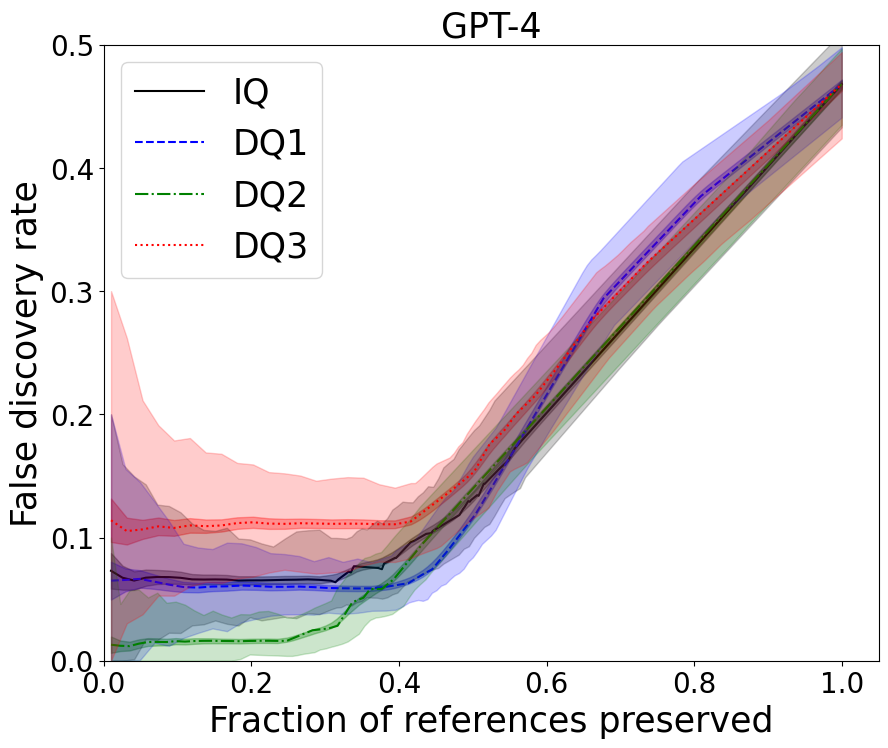

In [16]:
fdr_dict_data = [{"IQ":{"y":IQ_fdr,"x":IQ_return}},{"DQ1" : {"y":DQ1_fdr,"x":DQ1_return}},{"DQ2" : {"y":DQ2_fdr,"x":DQ2_return}},{"DQ3" : {"y":DQ3_fdr,"x":DQ3_return}}]
prompt_types = ["1","2","3","4"]

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['black','b', 'g', 'r']
linestyles = ['solid','dashed', 'dashdot', 'dotted']
# loop over the data and plot the ROC curve for each one
for i in range(len(fdr_dict_data)):
#for i in range(1):
    x = fdr_dict_data[i][list(fdr_dict_data[i].keys())[0]]["x"]
    y = fdr_dict_data[i][list(fdr_dict_data[i].keys())[0]]["y"]
    if prompt_types[i] == "1":
        return_min = np.min(IQ_return)
        return_max = np.max(IQ_return)
    if prompt_types[i] == "2":
        return_min = np.min(DQ1_return)
        return_max = np.max(DQ1_return)
    if prompt_types[i] == "3":
        return_min = np.min(DQ2_return)
        return_max = np.max(DQ2_return)
    if prompt_types[i] == "4":
        return_min = np.min(DQ3_return)
        return_max = np.max(DQ3_return)

    mean,fdr_lower,fdr_upper,fdr_lower_ci,fdr_upper_ci,ext_mean,ext_mean_fdr,ext_lower,ext_upper,ext_lower_ci,ext_upper_ci = get_all_data_with_extension(prompt_types[i],return_min,return_max)
    
    x = np.concatenate((ext_mean[:-1],x))
    y = np.concatenate((ext_mean_fdr[:-1],y))
    set_xy = zip(x,y)
    set_xy = sorted(set_xy)
    x,y = zip(*set_xy)

    x_mean = np.concatenate((ext_mean[:-1],mean))
    y_lower_ci = np.concatenate((ext_lower_ci[:-1],fdr_lower_ci))
    y_upper_ci = np.concatenate((ext_upper_ci[:-1],fdr_upper_ci))
    y_upper = np.concatenate((ext_upper[:-1],fdr_upper))
    y_lower = np.concatenate((ext_lower[:-1],fdr_lower))
    set_xy = zip(x_mean,y_lower_ci)
    set_xy = sorted(set_xy)
    x_mean,y_lower_ci = zip(*set_xy)
    set_xy = zip(x_mean,y_upper_ci)
    set_xy = sorted(set_xy)
    x_mean,y_upper_ci = zip(*set_xy)
    set_xy = zip(x_mean,y_upper)
    set_xy = sorted(set_xy)
    x_mean,y_upper = zip(*set_xy)
    set_xy = zip(x_mean,y_lower)
    set_xy = sorted(set_xy)
    x_mean,y_lower = zip(*set_xy)

    ax.plot(x,y, label=list(fdr_dict_data[i].keys())[0],color=colors[i],linewidth=1.5,linestyle = linestyles[i])
    ax.fill_between(x_mean,y_lower, y_upper,color=colors[i], alpha=.2,zorder=2)
    ax.fill_between(x_mean,y_lower_ci, y_upper_ci,color=colors[i], alpha=.3,zorder=1)
    ax.legend(loc='upper left',fontsize=25)
    ax.set_ylabel('False discovery rate',fontsize=25)
    ax.set_xlabel('Fraction of references preserved',fontsize=25)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_xlim([0, 1.05])
    ax.set_ylim([0, 0.50])
    print("done")
ax.set_title("GPT-4",fontsize=25)